In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import solve_ivp, odeint
import arviz as az
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from scipy import stats
import matplotlib as mpl
import time
import theano.tensor as tt
from theano.compile.ops import as_op
from collections import OrderedDict 


import warnings
warnings.filterwarnings("ignore")



add back in visualizations of tumor size given the parameters
models 2,3,4
time-it methods using a decorator
cull imports

mybinder (online git repos for notebooks)
generate requirements.txt

In [2]:
path_to_data = "filtered_data_csv.csv"
data = pd.read_csv(path_to_data)
data.head()


,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,51.786507,20.212286,31.930893,16.927490,48.806049,19.286955,43.664264,19.417161,30.988742,17.752230,44.409795,13.040341
1,14,66.185535,27.352276,53.804666,21.294581,69.038249,35.959695,46.313592,27.260107,34.640653,25.398323,60.142226,16.147825
2,23,100.841313,48.551059,67.105632,29.538706,126.046100,42.178934,85.785176,68.526077,61.905680,33.892752,135.849364,62.744238
3,29,205.291993,85.584746,141.023314,53.179914,241.478202,111.850683,251.086596,140.093869,134.994293,65.107710,207.222552,91.554513
4,34,334.876240,106.083280,225.843888,92.229404,393.011416,100.606232,443.482321,223.956685,257.324806,123.482982,303.385114,117.382875


In [3]:
data_array = data.to_numpy()
days = data_array[:,0]
tumor_sizes = data_array[:,1::2].T
tumor_sigmas = data_array[:,2::2].T
T0 = tumor_sizes[:,0]

print(tumor_sizes.shape)
print(T0.shape)




(6, 19)
(6,)


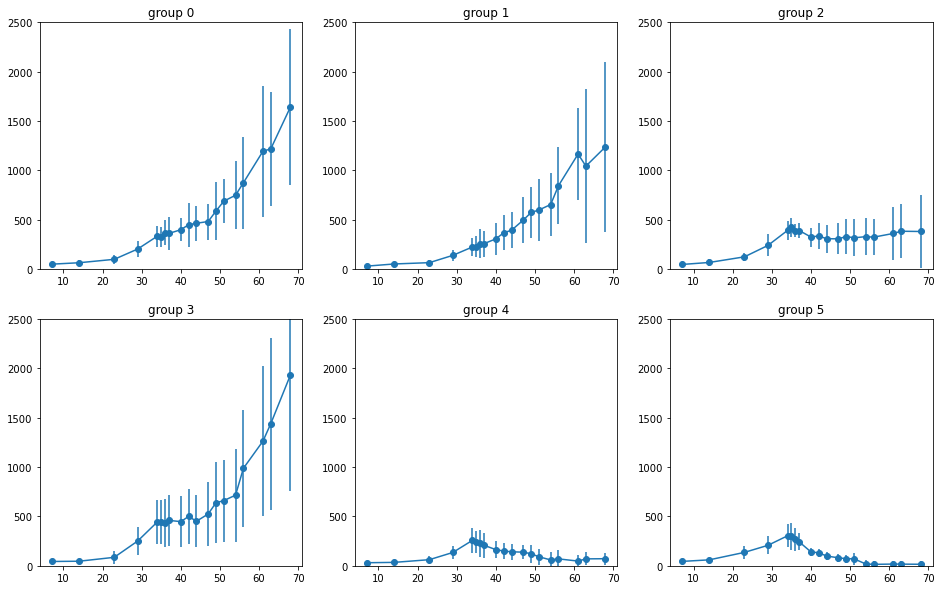

In [4]:
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[ii,:])
    plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
    plt.title("group {}".format(ii))
plt.show()

In [5]:

class growth_model(object):
    def simulate(self, fit_params, times=days):      
        return self.rhs(times, fit_params)
        
    def rhs(self, times, fit_params):
        return np.zeros((6,))
    
    def get_param(self, param_name):
        return pm.summary(self.trace)['mean'][param_name]
    
        
    def backward(self):
        with pm.Model() as model:
            #form priors
            #prior_distributions = [pm.Uniform(list(self.param_estimates.keys())[ii], lower=self.param_estimates[param][0], upper=self.param_estimates[param][1]) for ii, param in enumerate(self.param_list)]
            assert isinstance(self.param_estimates, OrderedDict)
            
            prior_distributions = [pm.Uniform(param_name, param_est[0], param_est[1]) for param_name, param_est in self.param_estimates.items()]
            
            prior_distributions = tt.as_tensor_variable(prior_distributions)
            
            @as_op(itypes=[tt.dvector], otypes=[tt.dmatrix]) 
            def th_forward_model(prior_distributions):
                th_states = self.simulate(prior_distributions)
                return th_states
            
            forward = th_forward_model(prior_distributions)
            
            
            T = pm.Normal('T', mu=forward, sigma=tumor_sigmas, observed=tumor_sizes)
            
            
            num_tune = self.num_samples//5
            
            #step = pm.SMC()
            step = pm.Metropolis()
            #prior = pm.sample_prior_predictive()
            self.trace = pm.sample(self.num_samples, step=step, tune=num_tune, chains = self.num_chains, cores=1)
            #trace = pm.sample_smc(kernel="ABC")
            
            pm.traceplot(self.trace)
            
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            
            #data = az.from_pymc3(trace=self.trace, prior = prior, posterior_predictive = posterior_predictive)
            data = az.from_pymc3(trace=self.trace, posterior_predictive = posterior_predictive)
            
            az.plot_posterior(data, round_to=4, credible_interval=0.95);


            t2 = time.time()
            print("sampling posteriors")
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            print("plotting posterior samples")
            #az.plot_trace(posterior_predictive)
            traceplot(posterior_predictive, show=True)
            t3 = time.time()
            print(t3-t2, "seconds")


            print("generating posterior distributions")
            #posterior_distribution = az.from_pymc3(trace=self.trace, prior=prior, posterior_predictive=posterior_predictive)
            posterior_distribution = az.from_pymc3(trace=self.trace, posterior_predictive=posterior_predictive)
            print("plotting posterior distribution")
            az.plot_posterior(posterior_distribution, show=True)
            #traceplot(posterior_distribution)
            t4 = time.time()
            print(t4-t3, "seconds")
            
            
            sim_times = days
            sim_params = []
            for param_name in self.param_estimates.keys():
                print(param_name + ' = ' + str(self.get_param(param_name)))
                sim_params.append(self.get_param(param_name))
                
            
            #visualize drug concentrations
            gm1.set_sim_DH(sim_params)
            plt.figure(figsize=(16,10))
            for ii in range(6):
                plt.subplot(2,3,ii+1)
                plt.xlim(7,70)
                plt.plot(gm1.sim_D['t'], gm1.sim_D['y'][ii,:])
                plt.plot(gm1.sim_H['t'], gm1.sim_H['y'][ii,:])
                plt.legend(["doxorubicin","herceptin"])
                plt.title("group {}".format(ii))
            plt.show()
            
            
            #visualize tumor growth
            sim_y = gm1.rhs(sim_times, sim_params)
            plt.figure(figsize=(16,10))
            for ii in range(6):
                plt.subplot(2,3,ii+1)
                plt.xlim(7,70)
                plt.ylim(0,2500)
                plt.scatter(days, tumor_sizes[ii,:])
                plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
                plt.plot(sim_times, sim_y[ii,:])
                plt.title("group {}".format(ii))
    
            plt.show()


            


## Growth Model 1


$$ \frac{d \phi_t}{dt} = r \phi_t - \lambda_h \phi_h \phi_t  - \lambda_{hd} \phi_h \phi_d \phi_t $$

$$ \frac{d \phi_d}{dt} = - \tau_d \phi_d + \delta (t - \eta_d) $$

$$ \frac{d \phi_h}{dt} = - \tau_h \phi_h + \delta (t - \eta_h) e^{-\lambda_{dh} \phi_d} $$

r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh

In [6]:

eps=1

class growth_model_1(growth_model):
    def __init__(self):
        super().__init__()
        
        """
        self.param_estimates = {
            'r':[0,1],
            'lambda_h': [0,1],
            'lambda_hd': [0,1],
            'tau_d': [0,1],
            'tau_h': [0, 1],
            'lambda_dh': [0,1],
        }
        """
        self.param_estimates = OrderedDict()
        self.param_estimates['r'] = [0,1]
        self.param_estimates['lambda_h'] = [0,1]
        self.param_estimates['lambda_hd'] = [0,1]
        self.param_estimates['tau_d'] = [0,1]
        self.param_estimates['tau_h'] = [0, 1]
        self.param_estimates['lambda_dh'] = [0,1]
        
        
        self.dose_time_D = np.array([[-1,-1],
                                     [-1,39],
                                     [-1,-1],
                                     [-1,35],
                                     [-1,39],
                                     [35,38]])
        
        self.dose_time_H = np.array([[-1,-1],
                                     [-1,-1],
                                     [35,38],
                                     [36,39],
                                     [35,38],
                                     [35,38]])
    
        
        #self.param_list = list(self.param_estimates.keys())
        
        self.num_samples = 50
        self.num_chains = 2
        self.t_span = (7,70)
        
    def set_sim_DH(self, fit_params):
        #print("rhs")
        self.sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        self.sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        
    
    def rhs(self, times, fit_params):
        #print("rhs")
        self.sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        self.sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        sim_T = solve_ivp(self.dTdt, self.t_span, T0, method='Radau', t_eval=times, max_step=eps, args=fit_params)
        return sim_T['y']
        
        
    def dTdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dTdt")
        #print(t)
        #sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=[t], max_step=eps, args=(r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh))
        D = self.get_y_of_t(t, self.sim_D['t'], self.sim_D['y'])
        
        #sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=[t], max_step=eps, args=(r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh, D))
        #H = sim_H['y'][:,0]
        H = self.get_y_of_t(t, self.sim_H['t'], self.sim_H['y'])
        #print(D.shape)
        #print(H.shape)
        
        return y*(r - lambda_h*H - lambda_hd*H*D)
    
    def dDdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dDdt")
        def activation(t):
            return (np.abs(self.dose_time_D[:,0]-t) <= eps) + (np.abs(self.dose_time_D[:,1]-t) <= eps)
    
        return -tau_d*y + activation(t)/(2*eps)
    
    def dHdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dHdt")
        def activation(t):
            return (np.abs(self.dose_time_H[:,0]-t) <= eps) + (np.abs(self.dose_time_H[:,1]-t) <= eps)
    
        D = self.get_y_of_t(t, self.sim_D['t'], self.sim_D['y'])
        #assert D.shape[0] == 6
        
        #print((-tau_h*y + activation(t)/(2*eps)*np.exp(D*(-lambda_dh))).shape)
        return -tau_h*y + activation(t)/(2*eps)*np.exp(D*(-lambda_dh))
    
    def get_y_of_t(self, t0, t, y):
        """
        print('t0',t0)
        #print('t0.shape',t0.shape)
        print('t',t)
        print('t.shape',t.shape)
        print('y',y)
        print('y.shape',y.shape)
        """
        if not any(np.abs(t-t0)<=eps):
            return np.zeros((6,))
        
        ret = y[:,np.abs(t-t0)<=eps]
        if ret is None:
            return np.zeros((6,))
        if len(ret) == 0:
            return np.zeros((6,))
        if ret == []:
            return np.zeros((6,))
        if len(ret.shape)>1:
            if ret.shape[1]>0:
                ret = ret[:,0]
            else:
                ret = ret.ravel()
        return ret
        
    

(6, 63)
(6, 63)
(63,)
(63,)


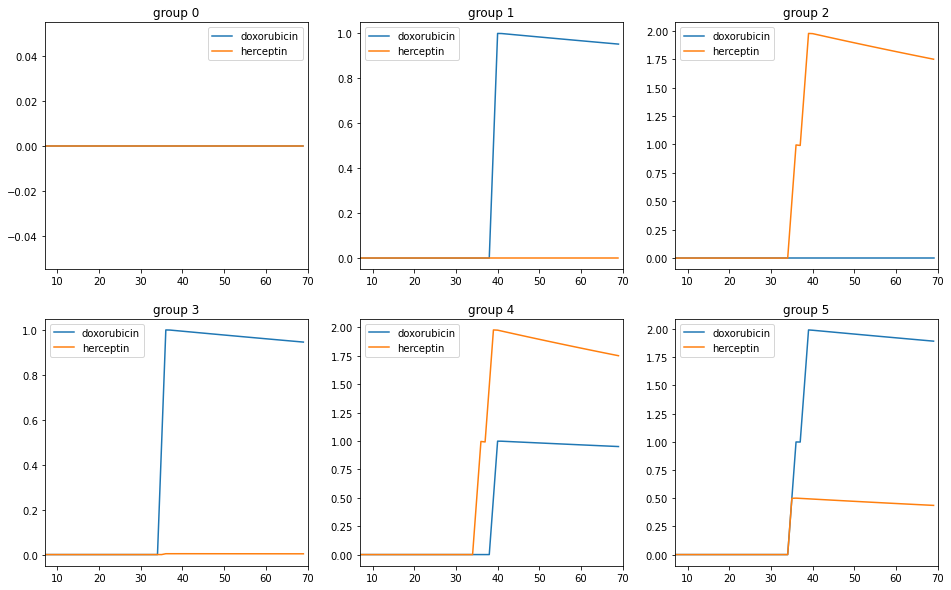

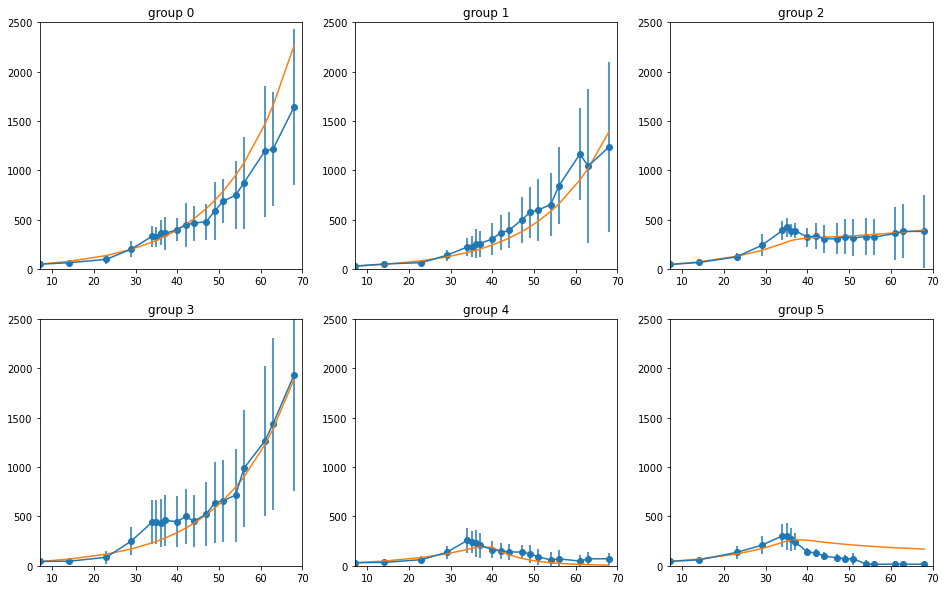

In [7]:
gm1 = growth_model_1()
r = 6.19e-2
lambda_h = 2.89e-2
lambda_hd = 7.03e-2
tau_d = 1.72e-3
tau_h = 4.17e-3
lambda_dh = 9.78
sim_params = np.array([r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh])
gm1.set_sim_DH(sim_params)

print(gm1.sim_D['y'].shape)
print(gm1.sim_H['y'].shape)
print(gm1.sim_D['t'].shape)
print(gm1.sim_H['t'].shape)
dense_times = gm1.sim_D['t']

plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.xlim(7,70)
    plt.plot(gm1.sim_D['t'], gm1.sim_D['y'][ii,:])
    plt.plot(gm1.sim_H['t'], gm1.sim_H['y'][ii,:])
    plt.legend(["doxorubicin","herceptin"])
    plt.title("group {}".format(ii))
plt.show()



#sim_times = dense_times
sim_times = days
sim_y = gm1.rhs(sim_times, sim_params)
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.xlim(7,70)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[ii,:])
    plt.errorbar(days, tumor_sizes[ii,:], tumor_sigmas[ii,:])
    plt.plot(sim_times, sim_y[ii,:])
    plt.title("group {}".format(ii))
    
plt.show()



## Fit backwards model

Only 50 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [lambda_dh]
>Metropolis: [tau_h]
>Metropolis: [tau_d]
>Metropolis: [lambda_hd]
>Metropolis: [lambda_h]
>Metropolis: [r]


Sampling 2 chains for 10 tune and 50 draw iterations (20 + 100 draws total) took 395 seconds.


sampling posteriors


plotting posterior samples


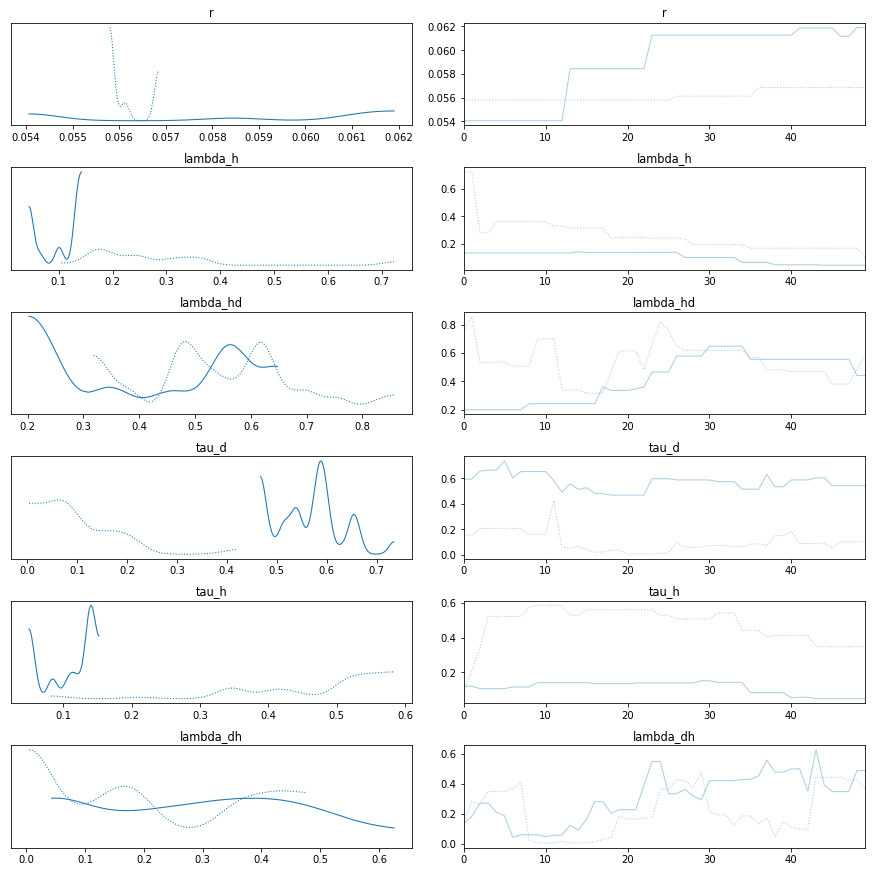

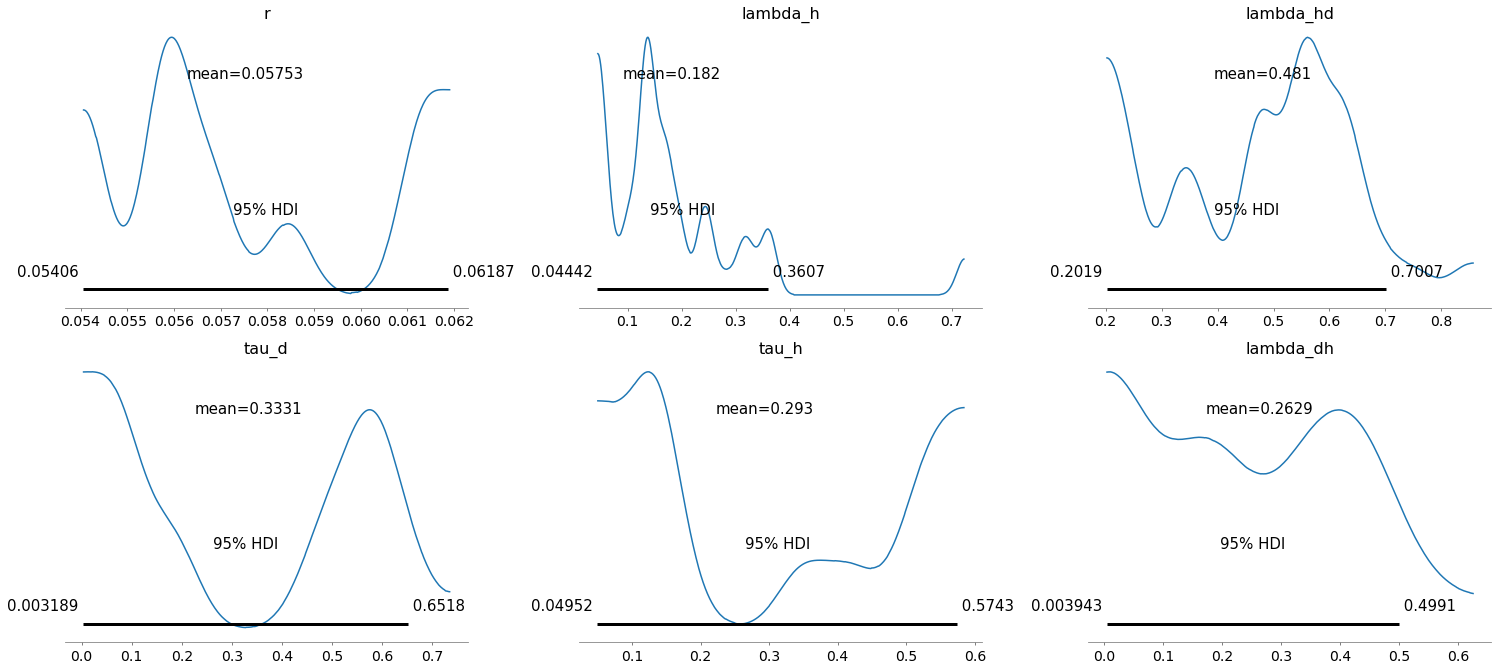

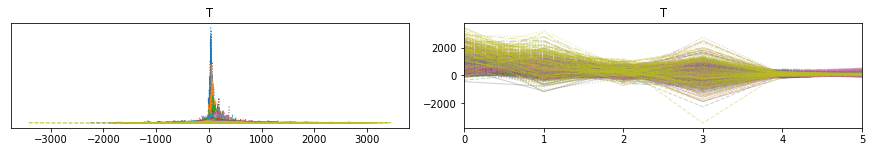

54.69183588027954 seconds
generating posterior distributions
plotting posterior distribution


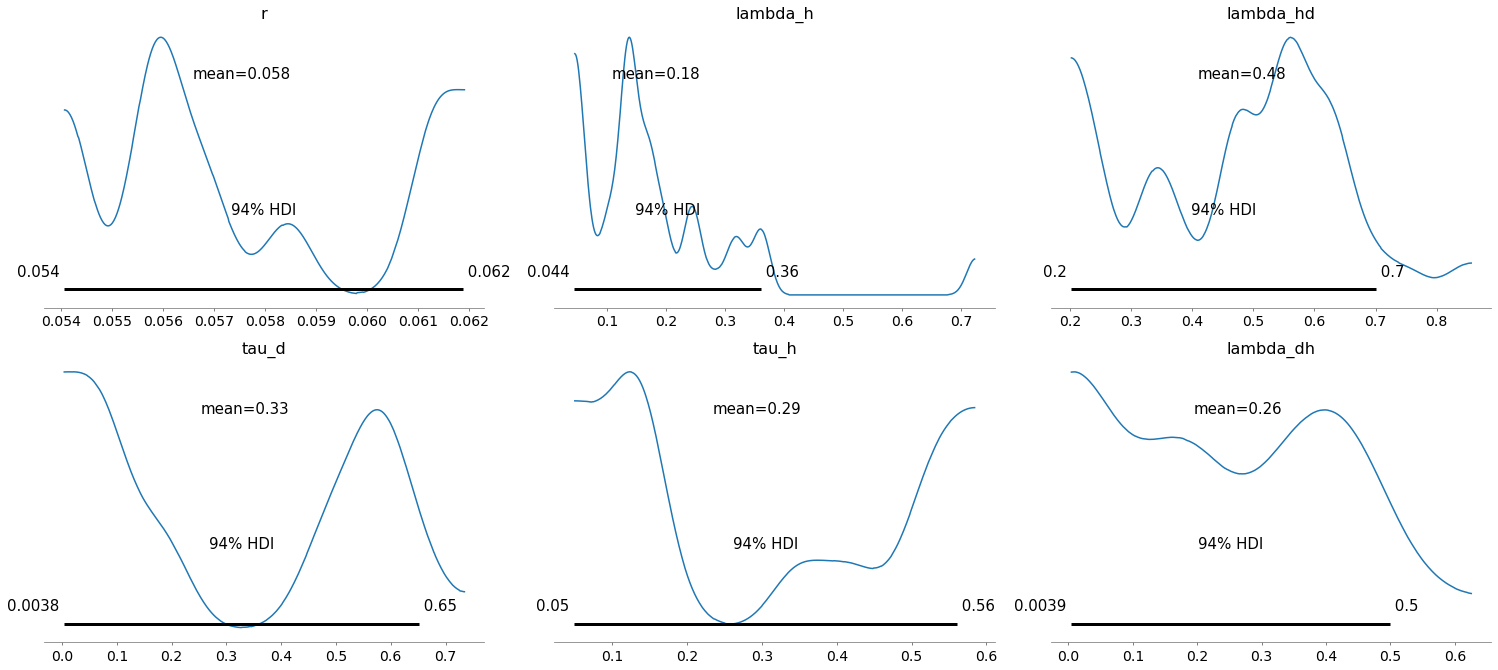

28.665706396102905 seconds
r = 0.058
lambda_h = 0.182
lambda_hd = 0.481
tau_d = 0.333
tau_h = 0.293
lambda_dh = 0.263


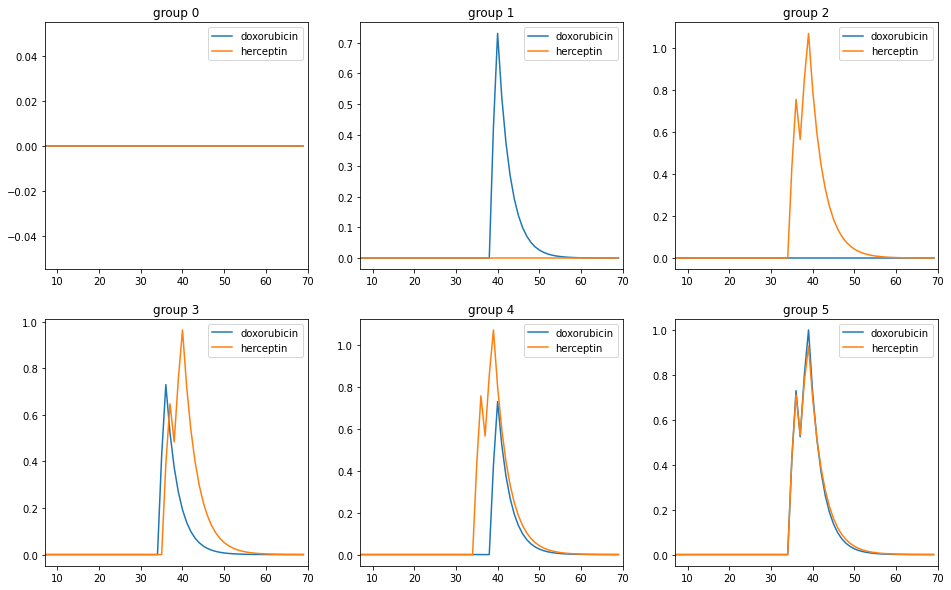

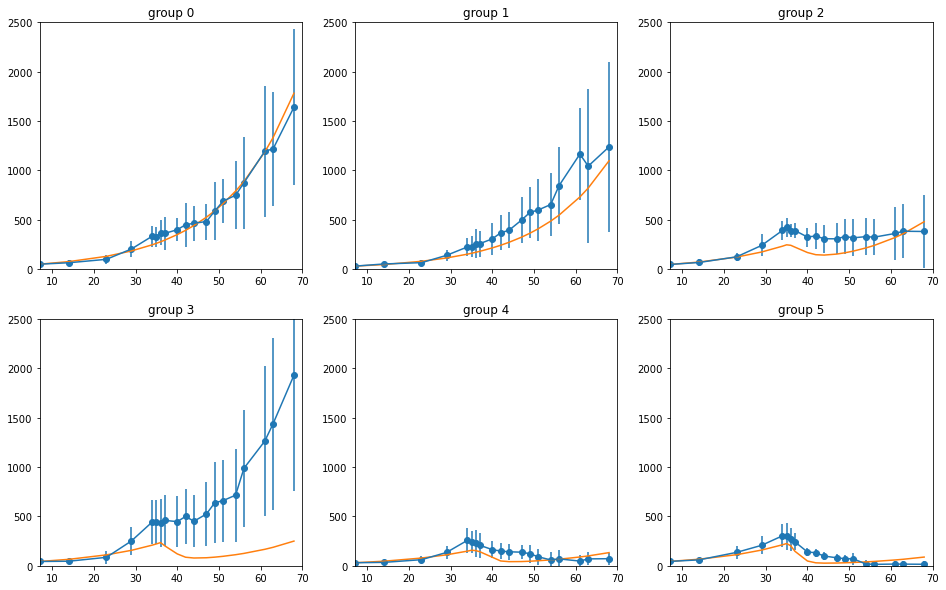

In [68]:
growth_model_1().backward()

In [ ]:
#dox_dose_days = np.array([[2, 7]])
"""
switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    
    
    
# Lotka - Volterra equation
def dy_dt(y, t, r):
    return np.array([y * r])

# simulator function
def differential_model(r):
    return solve_ivp(dy_dt, y0=y0, t=days, rtol=0.01, args=(r,))


s = pm.Simulator("s", normal_sim,
                     params=(a, b),
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)

trace, sim_data = pm.sample_smc(kernel="ABC",
                                            parallel=True,
                                            save_sim_data=True)
    
idata = az.from_pymc3(trace, posterior_predictive=sim_data)

trace = pm.sample_smc(num_samples, parallel=True)

https://docs.pymc.io/notebooks/SMC-ABC_Lotka-Volterra_example.html

   
    
    
"""

print('')

In [ ]:
eps = 1e-2
y0 = np.array(tumor_sizes[0,0:2])


def stiff_de(t, y, p):
    r = p[0]
    return [[y[0]*r,y[1]*r],[y[0]*r,y[1]*r]]

    #return y.row * r
    """
    x, y, z = p #unpack params
    output = []
    for group in range(len(y0.ravel())):
        output.append(func(y[group], params))
    return output
    """

    

#wrap the function to change the arguments order, so we can pass it to DifferentialEquation
def stiff_de_wrap(y, t, p):
    return stiff_de(t, y, p)

ode_model = DifferentialEquation(
    func = stiff_de_wrap,
    times=days,
    n_states=(2,2),
    n_theta=1,
    t0=7,    
)



num_samples = 300
num_chains = 10
tune_frac = 0.2

sampling priors
plotting prior samples


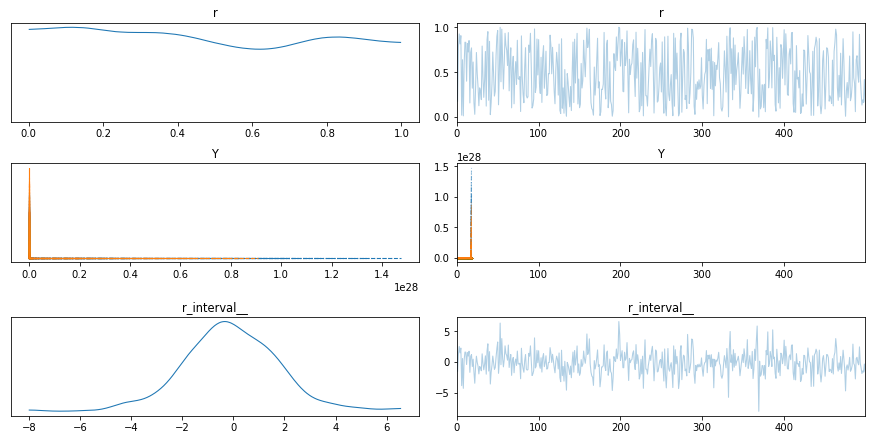

Only 300 samples in chain.
Sequential sampling (10 chains in 1 job)
Metropolis: [r]


running MCMC


Sampling 10 chains for 60 tune and 300 draw iterations (600 + 3_000 draws total) took 84 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


plotting MCMC trace


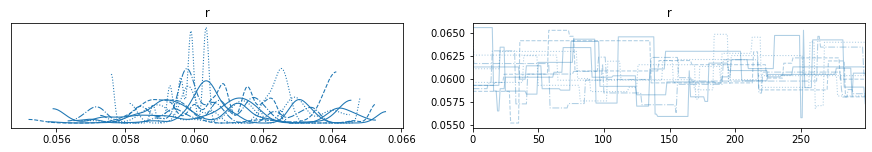

178.21289205551147 seconds
sampling posteriors


plotting posterior samples


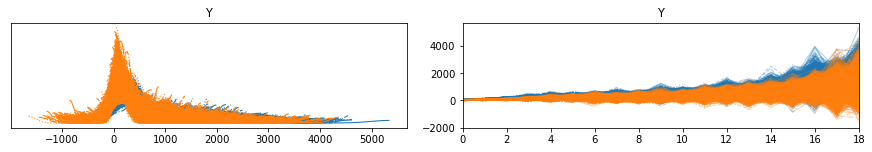

215.29160141944885 seconds
generating posterior distributions
plotting posterior distribution


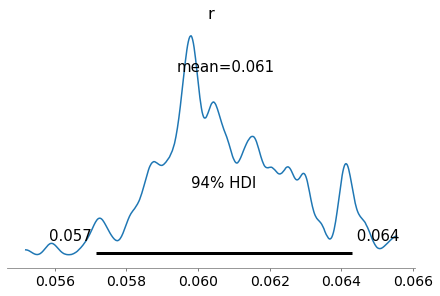

30.995904684066772 seconds
(6302,)
(2, 6302)


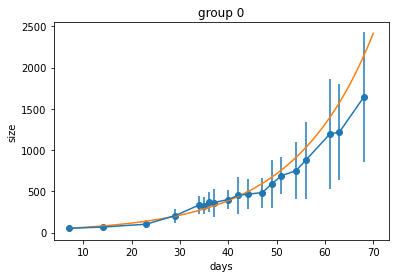

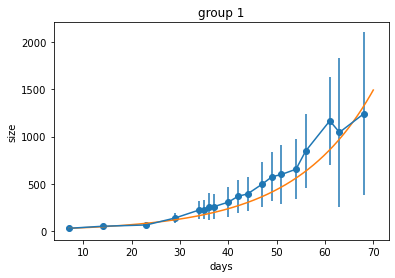

In [8]:

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    #dose = pm.Uniform('dose', 0, 100)
    r = pm.Uniform('r',0,1)
    
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=y0, theta=[r])
    
    # The ode_solution has a shape of (n_times, n_states)
    #print(ode_solution.shape)
    #print(sigma.shape)
    #print(ret['y'].shape)
    Y = pm.Normal('Y', mu=ode_solution, sigma=tumor_sigmas[:,0:2], observed=tumor_sizes[:,0:2]) #shape (2,)
    #Y = pm.Normal('Y', mu=ode_solution, sigma=np.ones_like(tumor_sizes[:,0:2]), observed=tumor_sizes[:,0:2])
    
    
    print("sampling priors")
    prior = pm.sample_prior_predictive()
    print("plotting prior samples")
    #az.plot_trace(prior)
    traceplot(prior, show=True)
    
    
    print("running MCMC")
    step = pm.Metropolis()
    t1 = time.time()
    trace = pm.sample(num_samples, tune=int(num_samples*tune_frac), chains=num_chains, cores=1, step=step)
    print("plotting MCMC trace")
    #az.plot_trace(trace)
    traceplot(trace, show=True)
    t2 = time.time()
    print(t2-t1, "seconds")
    
    
    print("sampling posteriors")
    posterior_predictive = pm.sample_posterior_predictive(trace)
    print("plotting posterior samples")
    #az.plot_trace(posterior_predictive)
    traceplot(posterior_predictive, show=True)
    t3 = time.time()
    print(t3-t2, "seconds")
    
    
    print("generating posterior distributions")
    posterior_distribution = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
    print("plotting posterior distribution")
    az.plot_posterior(posterior_distribution, show=True)
    #traceplot(posterior_distribution)
    t4 = time.time()
    print(t4-t3, "seconds")

    
    r_mean = pm.summary(trace)['mean']['r']
    
    t_span = (7, 70)
    #ret is a dict containing the integration of the DE
    sim = solve_ivp(stiff_de, t_span, y0, method='Radau', dense_output=True, max_step=eps, args=([r_mean],))
    #sim = solve_ivp(stiff_de, days, y0, method='Radau', dense_output=False, max_step=eps, args=([r_mean],))
    t_sim = sim['t']
    y_sim = sim['y']
    
    print(t_sim.shape)
    print(y_sim.shape)
    
    plt.figure()
    plt.scatter(days, tumor_sizes[:,0])
    plt.errorbar(days, tumor_sizes[:,0], tumor_sigmas[:,0])
    plt.plot(t_sim.ravel(), y_sim[0,:])
    plt.xlabel('days')
    plt.ylabel('size')
    plt.title("group 0")
    plt.show()
    
    plt.figure()
    plt.scatter(days, tumor_sizes[:,1])
    plt.errorbar(days, tumor_sizes[:,1], tumor_sigmas[:,1])
    plt.plot(t_sim.ravel(), y_sim[1,:])
    plt.xlabel('days')
    plt.ylabel('size')
    plt.title("group 1")
    plt.show()
    
    

## Growth Model 1


$$ \frac{d \phi_t}{dt} = r \phi_t - \lambda_h \phi_h \phi_t  - \lambda_{hd} \phi_h \phi_d \phi_t $$

$$ \frac{d \phi_d}{dt} = - \tau_d \phi_d + \delta (t - \eta_d) $$

$$ \frac{d \phi_h}{dt} = - \tau_h \phi_h + \delta (t - \eta_h) e^{-\lambda_{dh} \phi_d} $$

r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh

In [7]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [8]:
def normal_sim(r):
    return r


In [9]:
with pm.Model() as example:
    r = pm.Uniform("r", [0,1])
    s = pm.Simulator("s", normal_sim,
                     params=(r),
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)

    trace, sim_data = pm.sample_smc(kernel="ABC",
                                            parallel=False,
                                            save_sim_data=True)
    idata = az.from_pymc3(trace, posterior_predictive=sim_data)

Initializing SMC sampler...
Multiprocess sampling (8 chains in 8 jobs)
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.029
Stage:   4 Beta: 0.098
Stage:   5 Beta: 0.318
Stage:   6 Beta: 0.960
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.029
Stage:   4 Beta: 0.100
Stage:   5 Beta: 0.333
Stage:   6 Beta: 0.998
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.029
Stage:   4 Beta: 0.100
Stage:   5 Beta: 0.322
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.026
Stage:   4 Beta: 0.087
Stage:   5 Beta: 0.295
Stage:   6 Beta: 0.895
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.027
Stage:   4 Beta: 0.091
Stage:   5 Beta: 0.301
Stage:   6 Beta: 0.952
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   

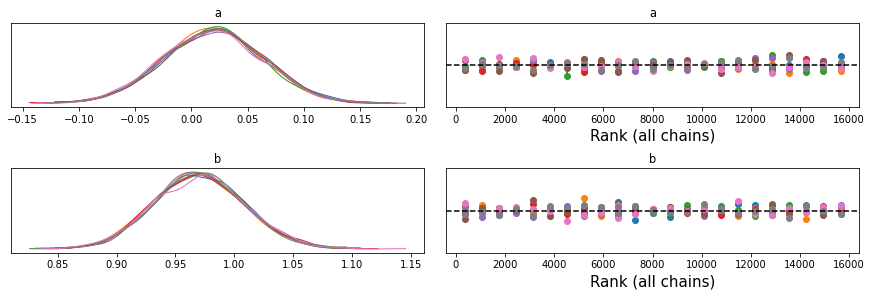

In [10]:

az.plot_trace(idata, kind="rank_vlines");

In [8]:
data_array = data.to_numpy()
days = data_array[:,0]
tumor_sizes = data_array[:,1::2].T
tumor_sigmas = data_array[:,2::2].T

T0 = tumor_sizes[:,0]

class growth_model(object):
    def simulate(self, fit_params, times=days):      
        return self.rhs(times, fit_params)
        
    def rhs(self, times, fit_params):
        return np.zeros((6,))
        
    def backward(self):
        with pm.Model() as model:
            #form priors
            prior_distributions = [pm.Uniform(list(self.param_estimates.keys())[ii], lower=self.param_estimates[param][0], upper=self.param_estimates[param][1]) for ii, param in enumerate(self.param_list)]
            
            prior_distributions = tt.as_tensor_variable(prior_distributions)
            
            @as_op(itypes=[tt.dvector], otypes=[tt.dmatrix]) 
            def th_forward_model(prior_distributions):
                th_states = self.simulate(prior_distributions)
                return th_states
            
            forward = th_forward_model(prior_distributions)
            
            
            T = pm.Normal('T', mu=forward, sigma=tumor_sigmas, observed=tumor_sizes)
            
            
            num_tune = self.num_samples//5
            
            #step = pm.SMC()
            step = pm.Metropolis()
            #prior = pm.sample_prior_predictive()
            self.trace = pm.sample(self.num_samples, step=step, tune=num_tune, chains = self.num_chains, cores=1)
            #trace = pm.sample_smc(kernel="ABC")
            
            pm.traceplot(self.trace)
            
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            
            data = az.from_pymc3(trace=self.trace, prior = prior, posterior_predictive = posterior_predictive)
            
            az.plot_posterior(data,round_to=4, credible_interval=0.95);


            t2 = time.time()
            print("sampling posteriors")
            posterior_predictive = pm.sample_posterior_predictive(self.trace)
            print("plotting posterior samples")
            #az.plot_trace(posterior_predictive)
            traceplot(posterior_predictive, show=True)
            t3 = time.time()
            print(t3-t2, "seconds")


            print("generating posterior distributions")
            posterior_distribution = az.from_pymc3(trace=self.trace, prior=prior, posterior_predictive=posterior_predictive)
            print("plotting posterior distribution")
            az.plot_posterior(posterior_distribution, show=True)
            #traceplot(posterior_distribution)
            t4 = time.time()
            print(t4-t3, "seconds")
            
            

    
    

In [10]:

eps=1

class growth_model_1(growth_model):
    def __init__(self):
        super().__init__()
        
        self.param_estimates = {
            'r':[0,1],
            'lambda_h': [0,1],
            'lambda_hd': [0,1],
            'tau_d': [0,1],
            'tau_h': [0, 1],
            'lambda_dh': [0,1],
        }
        
        self.dose_time_D = np.array([[-1,-1],
                                     [-1,39],
                                     [-1,-1],
                                     [-1,35],
                                     [-1,39],
                                     [35,38]])
        
        self.dose_time_H = np.array([[-1,-1],
                                     [-1,-1],
                                     [35,38],
                                     [36,39],
                                     [35,38],
                                     [35,38]])
    
    
        
        self.param_list = list(self.param_estimates.keys())
        
        self.num_samples = 20
        self.num_chains = 1
        self.t_span = (7,70)
    
    def rhs(self, times, fit_params):
        #print("rhs")
        self.sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        self.sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=np.arange(self.t_span[0], self.t_span[1], eps), max_step=eps, args=fit_params)
        sim_T = solve_ivp(self.dTdt, self.t_span, T0, method='Radau', t_eval=days, max_step=eps, args=fit_params)
        return sim_T['y']
        
        
    def dTdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dTdt")
        #print(t)
        #sim_D = solve_ivp(self.dDdt, self.t_span, [0]*6, method='Radau', t_eval=[t], max_step=eps, args=(r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh))
        D = self.get_y_of_t(t, self.sim_D['t'], self.sim_D['y'])
        
        #sim_H = solve_ivp(self.dHdt, self.t_span, [0]*6, method='Radau', t_eval=[t], max_step=eps, args=(r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh, D))
        #H = sim_H['y'][:,0]
        H = self.get_y_of_t(t, self.sim_H['t'], self.sim_H['y'])
        #print(D.shape)
        #print(H.shape)
        
        return y*(r - lambda_h*H - lambda_hd*H*D)
    
    def dDdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dDdt")
        def activation(t):
            return (np.abs(self.dose_time_D[:,0]-t) < eps) + (np.abs(self.dose_time_D[:,1]-t) < eps)
    
        return -tau_d*y + activation(t)/(2*eps)
    
    def dHdt(self, t, y, r, lambda_h, lambda_hd, tau_d, tau_h, lambda_dh):
        #print("dHdt")
        def activation(t):
            return (np.abs(self.dose_time_H[:,0]-t) < eps) + (np.abs(self.dose_time_H[:,1]-t) < eps)
    
        D = self.get_y_of_t(t, self.sim_D['t'], self.sim_D['y'])
        #assert D.shape[0] == 6
        
        #print((-tau_h*y + activation(t)/(2*eps)*np.exp(D*(-lambda_dh))).shape)
        return -tau_h*y + activation(t)/(2*eps)*np.exp(D*(-lambda_dh))
    
    def get_y_of_t(self, t0, t, y):
        """
        print('t0',t0)
        #print('t0.shape',t0.shape)
        print('t',t)
        print('t.shape',t.shape)
        print('y',y)
        print('y.shape',y.shape)
        """
        if not any(np.abs(t-t0)<eps):
            return np.zeros((6,))
        
        ret =  y[:,np.abs(t-t0)<eps]
        if ret is None:
            return np.zeros((6,))
        if len(ret) == 0:
            return np.zeros((6,))
        if ret == []:
            return np.zeros((6,))
        if len(ret.shape)>1:
            if ret.shape[1]>0:
                ret = ret[:,0]
            else:
                ret = ret.ravel()
        return ret
        
    

Only 100 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Metropolis: [lambda_dh]
>Metropolis: [tau_h]
>Metropolis: [tau_d]
>Metropolis: [lambda_hd]
>Metropolis: [lambda_h]
>Metropolis: [r]


Sampling 1 chain for 20 tune and 5 draw iterations (20 + 5 draws total) took 88 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


NameError: name 'prior' is not defined

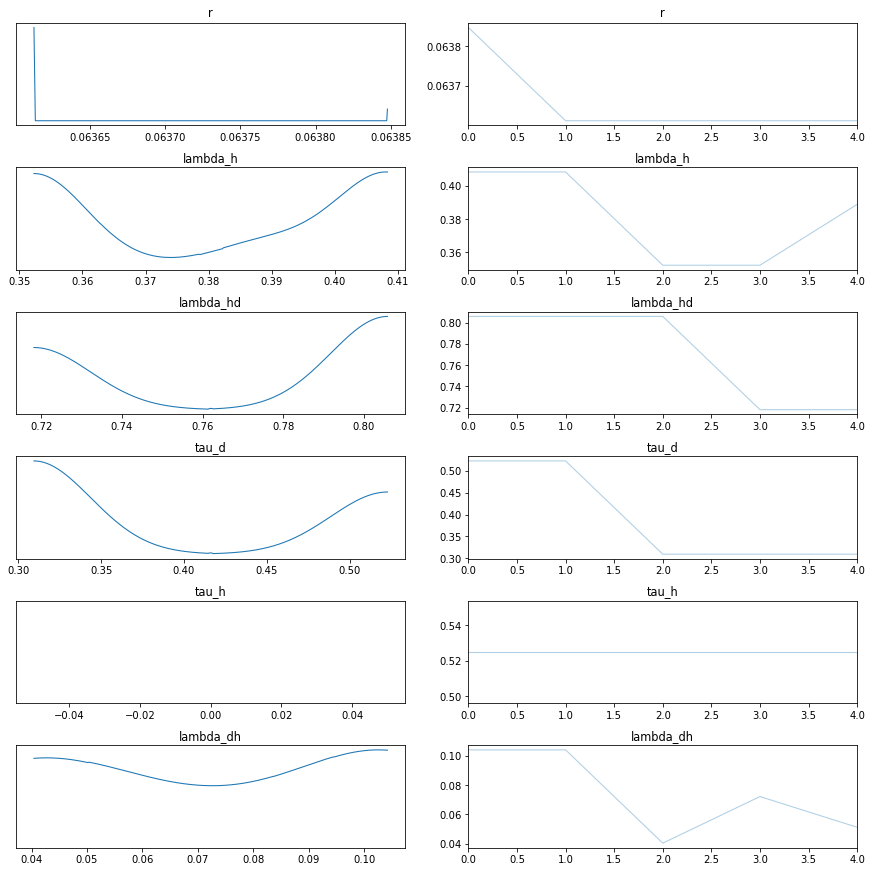

In [11]:
growth_model_1().backward()